In [1]:
# %%
# --- SETUP: Load Libraries and Prepare Data ---
import pandas as pd
import numpy as np
from pathlib import Path
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
print("Libraries imported.")

# Load the processed data for a sample stock (AAPL)
processed_data_path = Path("../data/processed/AAPL_processed.csv")
df = pd.read_csv(processed_data_path, index_col='Date', parse_dates=True)

print("Sample data for AAPL loaded.")

# --- Prepare Features for the HMM ---
# The model will learn from daily returns and volatility
# We use log returns for numerical stability
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# We use rolling 21-day volatility (approx. 1 trading month)
df['Volatility'] = df['Log_Returns'].rolling(window=21).std()

# Drop any NaN values created by the calculations
df.dropna(inplace=True)

# Create the feature matrix for the HMM
X = df[['Log_Returns', 'Volatility']].values

print("Feature matrix (X) created with shape:", X.shape)
df.head()

Libraries imported.
Sample data for AAPL loaded.
Feature matrix (X) created with shape: (3501, 2)


,Open,High,Low,Close,Volume,RSI,MACD,MACD_signal,EMA_20,EMA_50,EMA_200,BB_upper,BB_lower,BB_percent,ATR,OBV,Hurst,Log_Returns,Volatility
Date,,,,,,,,,,,,,,,,,,,
2011-02-01,10.369595,10.388228,10.247875,10.257493,426633200,54.936314,0.114066,0.129362,10.121013,9.844037,8.695766,10.539127,9.801517,0.618180,0.253661,14706792800,0.616930,0.016246,0.022885
2011-02-02,10.348254,10.376204,10.325112,10.352162,258955200,56.966476,0.119156,0.127321,10.143027,9.863964,8.712248,10.555672,9.821066,0.722967,0.244022,14965748000,0.627853,0.009187,0.022897
2011-02-03,10.321808,10.345852,10.174843,10.332628,393797600,56.401841,0.120227,0.125902,10.161085,9.882343,8.728371,10.557787,9.861778,0.676499,0.239257,14571950400,0.642274,-0.001889,0.022537
2011-02-04,10.413778,10.419789,10.323916,10.327823,321840400,56.254149,0.119313,0.124584,10.176964,9.899813,8.744286,10.567675,9.878698,0.651872,0.229015,14250110000,0.626770,-0.000465,0.022419
2011-02-07,10.575466,10.616639,10.448036,10.455549,485021600,59.304906,0.127426,0.125153,10.203496,9.921606,8.761314,10.591712,9.896437,0.804160,0.233287,14735131600,0.628926,0.012291,0.022331


In [2]:
# %%
# --- Train the Hidden Markov Model ---

# We will look for 3 hidden states (regimes)
n_regimes = 3

# Create the HMM model
# covariance_type="diag" is a standard choice for financial data
# n_iter=1000 ensures the model has enough iterations to converge
model = GaussianHMM(n_components=n_regimes, covariance_type="diag", n_iter=1000, random_state=42)

print("Training the HMM model...")
# Train the model on our feature matrix X
model.fit(X)

# Predict the hidden states (regimes) for each day
hidden_states = model.predict(X)

print("Model training complete.")
print(f"Predicted regimes for {len(hidden_states)} days.")

Training the HMM model...
Model training complete.
Predicted regimes for 3501 days.


In [3]:
# %%
# --- Analyze the Characteristics of Each Regime ---

# Add the predicted regimes to our DataFrame
df['Regime'] = hidden_states

print("--- Regime Characteristics ---")
for i in range(model.n_components):
    regime_data = df[df['Regime'] == i]
    
    mean_return = regime_data['Log_Returns'].mean() * 252  # Annualized
    mean_volatility = regime_data['Volatility'].mean() * np.sqrt(252) # Annualized
    
    print(f"\nRegime {i}:")
    print(f"  Annualized Return: {mean_return:.2%}")
    print(f"  Annualized Volatility: {mean_volatility:.2%}")
    print(f"  Number of Days: {len(regime_data)}")

--- Regime Characteristics ---

Regime 0:
  Annualized Return: -35.34%
  Annualized Volatility: 52.48%
  Number of Days: 337

Regime 1:
  Annualized Return: 31.70%
  Annualized Volatility: 18.66%
  Number of Days: 1732

Regime 2:
  Annualized Return: 26.57%
  Annualized Volatility: 30.75%
  Number of Days: 1432


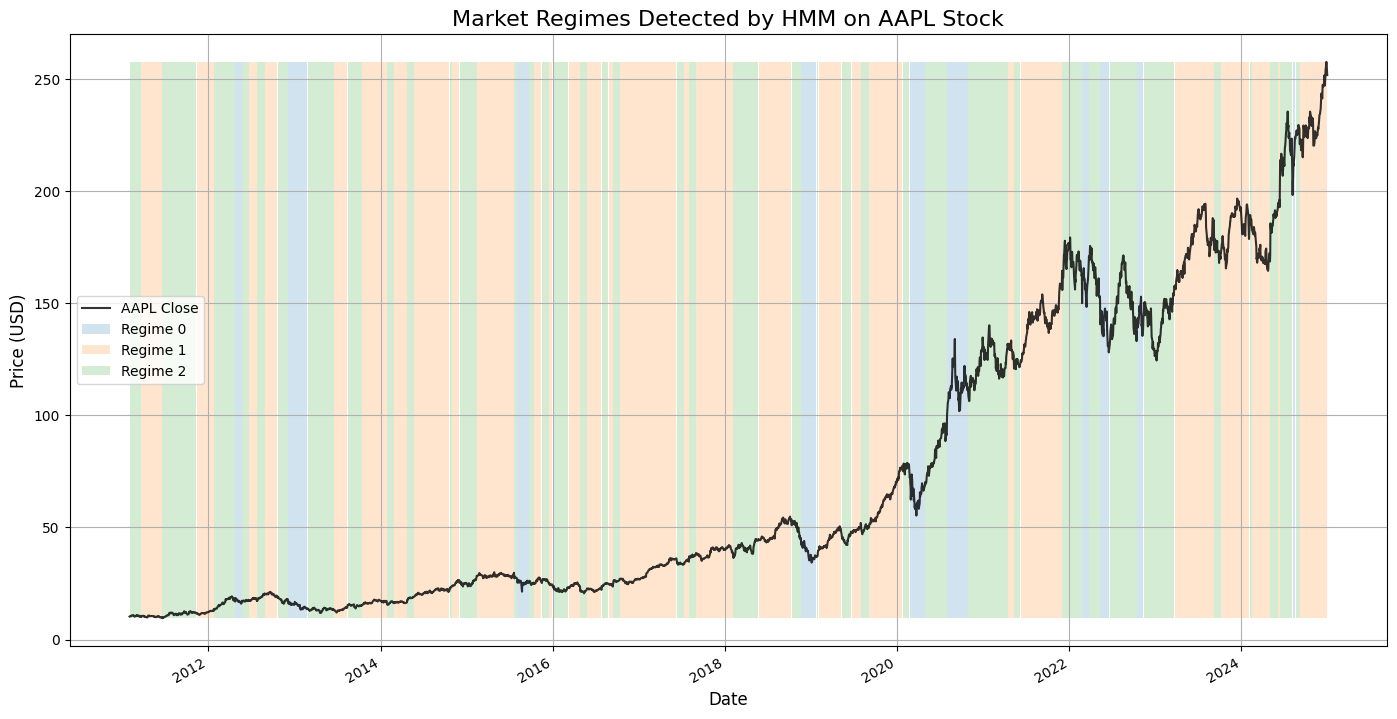

In [4]:
# --- Visualize the Regimes ---

plt.figure(figsize=(17, 9))

# Plot the closing price
ax = df['Close'].plot(label='AAPL Close', color='black', alpha=0.8, grid=True)

# Color the background for each regime
for i in range(model.n_components):
    regime_data = df[df['Regime'] == i]
    ax.fill_between(df.index, df['Close'].min(), df['Close'].max(), 
                     where=df['Regime'] == i, 
                     alpha=0.2, label=f'Regime {i}')

ax.set_title('Market Regimes Detected by HMM on AAPL Stock', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD)', fontsize=12)
ax.legend()
plt.show()